# 数据读入模块

In [39]:
import pandas as pd

train_data = pd.read_csv("data\main\df_train_b1.csv", index_col=0)
test_data = pd.read_csv('data\main\df_test_b1.csv', index_col=0)


## 要读入除了main之外的数在此处添加

In [40]:
import os
filenames = ["data\detail\df_basic_b1.csv",
             "data\detail\df_corp_b1.csv",
             "data\detail\df_judicial_b1.csv",
             "data\detail\df_loan2_b1.csv",
             "data\detail\df_query_b1.csv"]
for filename in filenames:
    temp = pd.read_csv(filename)
    train_data = pd.merge(train_data, temp, on="cust_id",
                          how="left", suffixes=("", "_y"))
    test_data = pd.merge(test_data, temp, on="cust_id",
                         how="left", suffixes=("", "_y"))


In [41]:
train_data['is_judicial']=[0 if pd.isna(i) else 1 for i in train_data['judicial_reason']]
test_data['is_judicial']=[0 if pd.isna(i) else 1 for i in test_data['judicial_reason']]

In [42]:
train_data['nan_num']=(train_data==0).astype(int).sum(axis=1)
test_data['nan_num']=(test_data==0).astype(int).sum(axis=1)

## 处理NAN

In [43]:
def delnan(df):
    df = df.dropna(how="all", axis=1)  # 删除全是空值的列
    df = df.fillna(-99)
    return df


In [44]:
df_train = delnan(train_data)
df_test = delnan(test_data)

In [45]:
#df_train.to_csv('data.csv')

## 处理-99

In [46]:
df_train.replace(-99,-1,inplace=True)
df_test.replace(-99,-1,inplace=True)

## 主成分分析

In [47]:
from sklearn.decomposition import PCA

full_col_name = list(df_train.columns)
pca_col=[i for i in full_col_name if "loan" in i]

modelPCA=PCA(n_components=0.9)
temp=modelPCA.fit_transform(df_train[pca_col])
temp1=modelPCA.transform(df_test[pca_col])
for i in range(temp.shape[1]):
    df_train['loan_pca'+str(i)]=temp[:,i]
    df_test['loan_pca'+str(i)]=temp1[:,i]

## 处理分类变量

In [48]:
type_col = ["basic_1",
            "basic_10",
            "basic_12",
            "basic_14",
            "loan1_16",
            "loan1_20",
            "loan1_23",
            "loan1_25",]

## 转化为one-hot编码（不宜采用）

In [49]:

def to_one_hot(df, colnames):
    df = pd.get_dummies(df, columns=colnames)
    return df


""" df_train = to_one_hot(df_train, type_col)
df_test = to_one_hot(df_test, type_col)
for i in df_train.columns:
    if i not in df_test.columns:
        df_test[i] = 0
 """

' df_train = to_one_hot(df_train, type_col)\ndf_test = to_one_hot(df_test, type_col)\nfor i in df_train.columns:\n    if i not in df_test.columns:\n        df_test[i] = 0\n '

## 证据权重

In [50]:
import pandas as pd
import numpy as np

def cal_woe(df,df_no_label,x_cols,y_col):
    for i in x_cols:
        x_set=pd.unique(df[i])
        for j in x_set:
            woe=np.mean(df[df[i]==j][y_col])
            df[i].replace(j,woe,inplace=True)
            df_no_label[i].replace(j,woe,inplace=True)
    return df,df_no_label

In [51]:
#df_train,df_test=cal_woe(df_train,df_test,type_col,"label")

In [52]:
full_col_name = list(df_train.columns)
basic_col = [i for i in full_col_name if "basic" in i]
loan_col = [i for i in full_col_name if "loan" in i]
overdue_col = [i for i in full_col_name if "overdue" in i]
query_col = [i for i in full_col_name if "query" in i]
judicial_col=[i for i in full_col_name if "judicial" in i]
loan_pca_col=[i for i in full_col_name if "loan_pca" in i]

""" for i in judicial_col:
    df_train[i].astype("float")
    df_test[i].astype("float") """

' for i in judicial_col:\n    df_train[i].astype("float")\n    df_test[i].astype("float") '

## 设置哪些x作为模型自变量输入

In [53]:
x_col = basic_col+['is_judicial']+loan_pca_col+query_col+overdue_col
# x_col为模型读入的自变量列名称


""" x_col=['loan2_3_y',
 'loan1_6',
 'loan1_32',
 'loan1_31',
 'basic_7',
 'loan2_4_y',
 'loan2_3',
 'loan1_15',
 'loan2_5_y',
 'loan1_30',
 'loan1_7',
 'loan1_3',
 'query_1',
 'query_7',
 'loan1_17',
 'query_4',
 'loan1_14',
 'basic_1_y',
 'loan1_21',
 'query_1_y'] """

" x_col=['loan2_3_y',\n 'loan1_6',\n 'loan1_32',\n 'loan1_31',\n 'basic_7',\n 'loan2_4_y',\n 'loan2_3',\n 'loan1_15',\n 'loan2_5_y',\n 'loan1_30',\n 'loan1_7',\n 'loan1_3',\n 'query_1',\n 'query_7',\n 'loan1_17',\n 'query_4',\n 'loan1_14',\n 'basic_1_y',\n 'loan1_21',\n 'query_1_y'] "

In [54]:
# df_train.drop(columns=drop_col)

# 训练模型

## 划分测试集训练集

In [55]:
""" from sklearn import model_selection


X = df_train[x_col]
Y = df_train["label"]
seed = 666
test_size = 0.1
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, Y, test_size=test_size, random_state=seed) """


' from sklearn import model_selection\n\n\nX = df_train[x_col]\nY = df_train["label"]\nseed = 666\ntest_size = 0.1\nX_train, X_test, y_train, y_test = model_selection.train_test_split(\n    X, Y, test_size=test_size, random_state=seed) '

## 训练模型

## 超参数

In [56]:
N = 100
num_round = 100
local_test_size=3000

max_depth = [3, 4, 5,6,7,8]
eta = [0.1,0.06]
colsample_bytree = [0.8,0.7, 0.6,0.5]
scale_pos_weight = [1, 3, 6, 10,20, 30]
test_size=[0.3,0.5,0.7]
subsample=[0.7,0.6,0.5,0.4]
par_lambda=[1,1.5,2,3]
alpha=[0,0.2,0.4,0.6,0.8]
min_child_weight=[1,2,3,4,5,6,10]


### train划分为
* 本地测试集（固定）d_localtest
* 训练集（固定）
  * 评估集（每次的模型不同）dtest
  * 真正的训练集（每次的模型不同）dtrain

In [57]:
import copy
import xgboost as xgb
import random
from sklearn import model_selection
from sklearn.metrics import roc_auc_score


pred_labels = []
local_test_labels = []
loss_seq = []
max_auc_loss = 0
flag=0
important_x_seq=[]

num_seq=list(range(len(df_train)))
np.random.shuffle(num_seq)

X_local_test=df_train[x_col].iloc[num_seq[0:local_test_size]]
Y_local_test=df_train["label"].iloc[num_seq[0:local_test_size]]

d_localtest=xgb.DMatrix(X_local_test,label=Y_local_test)

X = df_train[x_col].iloc[num_seq[local_test_size:len(df_train)]]
Y = df_train['label'].iloc[num_seq[local_test_size:len(df_train)]]
x_perd = xgb.DMatrix(df_test[x_col])

for i in range(N):

    #seed = 666
    test_size_this_round=random.choice(test_size)
    X_train, X_test, y_train, y_test = model_selection.train_test_split(
        X, Y, test_size=test_size_this_round)
    # seed+=1

    
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)
    evallist = [(dtest, 'eval')]

    param = {
        'max_depth': random.choice(max_depth),
        'eta': random.choice(eta),
        'colsample_bytree': random.choice(colsample_bytree),
        'objective': 'binary:logistic',
        #'verbosity':0,
        'scale_pos_weight': random.choice(scale_pos_weight),
        'eval_metric': 'auc',
        'subsample':random.choice(subsample),
        'alpha':random.choice(alpha),
        'lambda':random.choice(par_lambda),
        'min_child_weight':random.choice(min_child_weight),
        #'seed': 666,
        'tree_method': 'gpu_hist',
        'gpu_id': 0,
        #"enable_enable_categorical":True,
    }
    
    bst = xgb.train(param, dtrain, num_round, evals=evallist,
                    early_stopping_rounds=5, verbose_eval=False)
    
    loss = float(bst.eval(dtest).split(":")[1])
    train_loss = float(bst.eval(dtrain).split(":")[1])
    local_test_loss = float(bst.eval(d_localtest).split(":")[1])

    pred_label = list(bst.predict(x_perd))
    test_label = list(bst.predict(xgb.DMatrix(X_local_test)))
    # temp=roc_auc_score(y_test,test_label)
    # print(test_label[0:10])


    temp_dict={"test_auc":loss,"train_auc":train_loss,'local_test_auc':local_test_loss,'test_size':test_size_this_round}
    temp_dict.update(param)

    #info_df=info_df.append(pd.DataFrame(temp_dict))
    if flag==0:
        info_df=pd.DataFrame(temp_dict,index=[i])
        flag=1
    else:
        info_df=pd.concat([info_df,pd.DataFrame(temp_dict,index=[i])])

    if loss > max_auc_loss:
        best_bst = copy.deepcopy(bst)
        max_auc_loss = loss
    
    if False:
        pic=xgb.plot_importance(bst,max_num_features=50)
        temp=pic.get_ymajorticklabels()
        important_x=[str(i).split("\'")[1] for i in temp]
        important_x.reverse()
        important_x_seq+=important_x

    print(i+1, ":", loss, sep="")
    #print(param)
    #print("-------------------------")
    pred_labels.append([j for j in pred_label])
    local_test_labels.append(copy.deepcopy(test_label))


print('最大AUC:', max(info_df['local_test_auc']), sep="")

1:0.6271441501277331
2:0.6591587192566172
3:0.6249028661882394
4:0.6041022324015209
5:0.6409997913243441
6:0.6553719462157523
7:0.6009290762656148
8:0.5677321326628323
9:0.6558558224136011
10:0.6557060048981055
11:0.6188291376430153
12:0.6169255510301209
13:0.6606152518599435
14:0.6146566129739207
15:0.6167667583219337
16:0.5
17:0.5833626031940486
18:0.618834019008362
19:0.6300093840357069
20:0.6574232023574296
21:0.6165165285529625
22:0.615935260115607
23:0.6210331449836897
24:0.6366599283397085
25:0.672509849205271
26:0.6226181463150623
27:0.5993250636868921
28:0.6015869021205456
29:0.6144713462332213
30:0.5
31:0.625800231225842
32:0.643140008765489
33:0.627061559997053
34:0.49891502650395153
35:0.603418417813384
36:0.5100512664301003
37:0.6451840440100108
38:0.6251336435672896
39:0.6054090230074965
40:0.6087057373339383
41:0.6296555880191097
42:0.60790601243953
43:0.6378485023041475
44:0.6233422625688735
45:0.5917291976475436
46:0.6047158066717377
47:0.6473698470038249
48:0.61146786

In [58]:
info_df

,test_auc,train_auc,local_test_auc,test_size,max_depth,eta,colsample_bytree,objective,scale_pos_weight,eval_metric,subsample,alpha,lambda,min_child_weight,tree_method,gpu_id
0,0.627144,0.712608,0.606199,0.3,4,0.10,0.6,binary:logistic,1,auc,0.7,0.8,1.0,5,gpu_hist,0
1,0.659159,0.817441,0.678771,0.3,4,0.10,0.7,binary:logistic,6,auc,0.6,0.4,1.5,4,gpu_hist,0
2,0.624903,0.956956,0.593687,0.5,8,0.10,0.7,binary:logistic,10,auc,0.5,0.8,1.5,2,gpu_hist,0
3,0.604102,0.949687,0.677495,0.3,8,0.10,0.7,binary:logistic,30,auc,0.7,0.4,2.0,5,gpu_hist,0
4,0.641000,0.939652,0.620762,0.3,8,0.06,0.5,binary:logistic,6,auc,0.5,0.4,1.5,1,gpu_hist,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.634863,0.836521,0.636423,0.7,4,0.10,0.6,binary:logistic,10,auc,0.4,0.2,3.0,10,gpu_hist,0
96,0.600608,0.876654,0.680878,0.5,7,0.10,0.8,binary:logistic,20,auc,0.5,0.6,2.0,4,gpu_hist,0
97,0.653654,0.791732,0.704535,0.3,3,0.10,0.7,binary:logistic,30,auc,0.7,0.8,2.0,4,gpu_hist,0
98,0.629846,0.951445,0.662461,0.3,8,0.06,0.7,binary:logistic,20,auc,0.6,0.0,2.0,4,gpu_hist,0


In [59]:
info_df.to_csv("info.csv",encoding="utf-8",index=False)

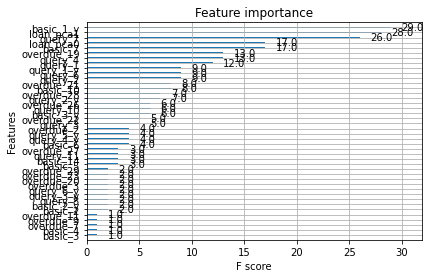

In [60]:
pic=xgb.plot_importance(best_bst,max_num_features=50)
temp=pic.get_ymajorticklabels()
important_x=[str(i).split("\'")[1] for i in temp]
important_x.reverse()

In [61]:
important_x

['basic_1_y',
 'loan_pca1',
 'query_7',
 'loan_pca0',
 'basic_7',
 'overdue_19',
 'query_4',
 'query_1',
 'query_1_y',
 'query_6',
 'query_2',
 'overdue_21',
 'basic_10',
 'overdue_28',
 'query_2_y',
 'overdue_26',
 'query_10',
 'basic_3_y',
 'overdue_22',
 'query_3',
 'overdue_2',
 'query_5_y',
 'query_4_y',
 'basic_6',
 'overdue_27',
 'query_11',
 'basic_14',
 'basic_5',
 'overdue_29',
 'overdue_23',
 'overdue_20',
 'overdue_3',
 'query_6_y',
 'query_3_y',
 'query_8',
 'basic_2_y',
 'basic_2',
 'overdue_11',
 'overdue_9',
 'overdue_7',
 'basic_4',
 'basic_3']

In [62]:
#pd.value_counts(important_x_seq)

* basic_7:年龄
* 

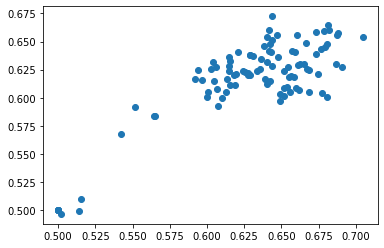

In [63]:
import matplotlib.pyplot as plt
plt.scatter(info_df['local_test_auc'],info_df['test_auc'])

# 输出模块

In [64]:
import time
import numpy as np
from sklearn.metrics import roc_auc_score

date = time.strftime("%Y%m%d-%H%M%S", time.localtime())
res_num = np.argsort([-i for i in info_df['local_test_auc']])

# 选择前n个结果进行平均（手动指定or在本地测试集排序选出）
if False:
    max_auc = -1
    list_temp = []
    for i in range(N):
        list_temp.append(local_test_labels[res_num[i]])
        temp = np.mean(list_temp, axis=0)
        temp_auc = roc_auc_score(Y_local_test, temp)
        print(i, temp_auc)
        if temp_auc > max_auc:
            max_auc = temp_auc
            n = i
else:
    n = 200
    n=min(N,n)

res_num = res_num[0:n]

final_pred_label = np.mean([pred_labels[i] for i in res_num], axis=0)
#local_auc = roc_auc_score(y_test, final_pred_label)
print("本地测试集前", n, "个auc为", [list(info_df['local_test_auc'])[i] for i in res_num], sep="")
#print("平均之后AUC为",local_auc,sep="")

res = pd.DataFrame({
    'cust_id': list(df_test["cust_id"]),
    'label': final_pred_label,
})
res.to_csv("./output/result"+date+".csv", encoding="utf-8", index=False)


本地测试集前100个auc为[0.7045345100222337, 0.691044026789709, 0.6882127329669842, 0.6873384130410282, 0.6863974945269622, 0.6817031478932647, 0.6815904425903094, 0.6808783499943647, 0.6804770508095997, 0.6790614038982373, 0.6787711023603222, 0.6774954832496013, 0.6769080495493496, 0.6743465653912752, 0.6734995679630054, 0.6734585842164762, 0.6684927202620228, 0.6684568594838097, 0.6672939456760439, 0.6665442846457809, 0.665340387091486, 0.6624612788978105, 0.6621368242377877, 0.6613769172708923, 0.660688731860423, 0.6597221985047763, 0.6594865419622334, 0.6585387928237459, 0.656826013750047, 0.6562078422398984, 0.6555162415172183, 0.6549680839073904, 0.6543396664606095, 0.6539212907147907, 0.6519130871348604, 0.6518772263566474, 0.6516996301216875, 0.6490373942533957, 0.649011779411815, 0.6479871857485852, 0.6473792601750689, 0.6437590292316572, 0.643432866915529, 0.6433696836396299, 0.642982045703708, 0.6424185191889317, 0.6421914009269157, 0.6418430390814176, 0.6415424916068703, 0.6404905754

# 一些tips

* 提升n有一定提升(如何确定n？)
  * n=40 0.6763
  * n=10 0.6728
  * n=100 0.6774
  * 太大也不好

# 一些进展

* 随机参数
* XGB模型
* 本地测试集auc较高（0.75+）
* 部分类型变量进行了one-hot处理
* 把细分表除了loan与主表合并

# tbd

* 处理细分表的loan，给出指标
* 确定变量类型，以便对所有（or重要）分类变量进行one-hot处理
* 新模型？

## 10-12
* 0.6824（这次我留了代码\doge）
* 把-99变为-1，本地有提升
* 划出了一个本地测试集
  * 本地测试集（固定）d_localtest
  * 训练集（固定）
    * 评估集（每次的模型不同）dtest
    * 真正的训练集（每次的模型不同）dtrain
* 添加参数nan_num（然并卵）
* tbd
  * 找特征
  * 加x
  * 分析一下参数作用